In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import random

In [3]:
from keras import layers, models
import keras
import matplotlib.pyplot as plt
import cv2
import os

2024-08-15 22:58:56.210405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 22:58:56.233984: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 22:58:56.241077: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 22:58:56.338520: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def getData(target, n={} ,k=99999999, m=99999999):
    data = {}
    dataLabels = []
    splits = os.listdir(target)
    for split in splits[:k]:
        data[split] = {'X':[], 'y':[]}
        if dataLabels == []: #avoid potentially different read order
            labels = sorted(os.listdir(target+f'{split}/'))
            dataLabels = labels
        for label in dataLabels[:m]:
            files = os.listdir(target+f'{split}/{label}/')
            random.shuffle(files)
            for file in files[:n[split]]:
                data[split]['X'].append(f'{target}{split}/{label}/{file}')
                y_temp = [0]*min(len(dataLabels), m)
                y_temp[dataLabels.index(label)] = 1
                data[split]['y'].append(np.asarray(y_temp))
        data[split]['X'] = np.asarray(data[split]['X'])
        data[split]['y'] = np.asarray(data[split]['y'])
    return data, dataLabels, splits

class My_Custom_Generator(keras.utils.Sequence):

    def __init__(self, image_filenames, labels, batch_size, img_size) :
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = img_size


    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int32)


    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

        return np.array([
                cv2.resize(cv2.imread(str(file_name)), self.image_size)
                    for file_name in batch_x])/255.0, np.array(batch_y)

In [5]:
def predictedValue(predictions):
    actual = []
    for prediction in predictions:
        i = np.argmax(prediction)
        actual.append(i)
    return actual

In [6]:
def testModel(dataset, M, N):

    if dataset == 'ImageNet':
        target = "./Data/150_subset/"
    elif dataset == 'Games':
        target = "./Data/Games/DATA BACKUP/"

    data, dataLabels, splits = getData(target, N, m=M)

    my_testing_batch_generator = My_Custom_Generator(data['test']['X'], data['test']['y'], 128, (256,256))
    
    model = keras.saving.load_model(f'models/cnn_{dataset}_{M:03d}_N-{N["train"]:04d}.keras')


    pred = predictedValue(model.predict(my_testing_batch_generator, verbose=1))
    cm = confusion_matrix(predictedValue(data['test']['y']), pred)
    disp = ConfusionMatrixDisplay.from_predictions(predictedValue(data['test']['y']), pred, include_values=False)
    plt.rcParams.update({'font.size': 14})
    plt.gca().axes.get_xaxis().set_ticks([])
    plt.gca().axes.get_yaxis().set_ticks([])
    plt.title(dataset)
    plt.savefig(f'Figures/{dataset}-{M}_confusion.svg')
    #disp.plot()
    return cm
    


In [13]:
M=150
N={ #max samples per split #This block defines N according to testing needs
    'test':3000,
    'train':1000,
    'val':65
}

/home/king/miniconda3/envs/TensorFlows/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


228/228 ━━━━━━━━━━━━━━━━━━━━ 65s 285ms/step


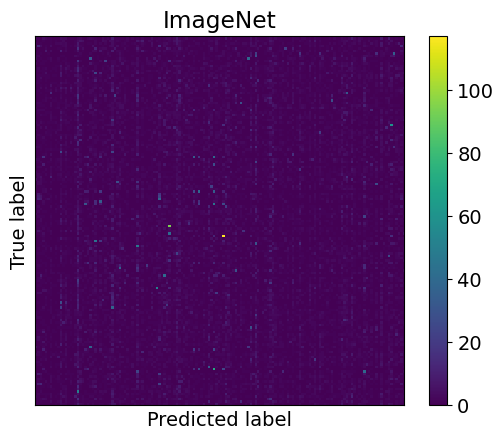

In [14]:
imagenet_red = testModel('ImageNet', M, N)
#game_res = testModel('Games', M, N)

In [9]:
callbacks = [
keras.callbacks.ModelCheckpoint(
    filepath="callback.keras",
    save_best_only=True,
    monitor="val_accuracy")
]

In [10]:
labels = sorted(os.listdir('Data/150_subset/train'))

In [11]:
individual_acc = {}
for i in range(len(labels)):
    #individual_acc[labels[i]] = game_res[i,i]
    individual_acc[labels[i]] = imagenet_red[i,i]/N['test']*100

In [12]:
for v, k in sorted( ((v,k) for k,v in individual_acc.items()), reverse=True):
    print(f'{k} : {v:0.2f}%')

brambling : 0.67%
king snake : 0.37%
common iguana : 0.27%
magpie : 0.20%
black grouse : 0.17%
trilobite : 0.13%
sidewinder : 0.13%
ringneck snake : 0.13%
ptarmigan : 0.13%
centipede : 0.13%
bulbul : 0.13%
Dungeness crab : 0.13%
African chameleon : 0.13%
whiptail : 0.10%
vulture : 0.10%
quail : 0.10%
jay : 0.10%
bullfrog : 0.10%
European fire salamander : 0.10%
wombat : 0.07%
thunder snake : 0.07%
tailed frog : 0.07%
spotted salamander : 0.07%
spoonbill : 0.07%
snail : 0.07%
rock python : 0.07%
oystercatcher : 0.07%
macaw : 0.07%
horned viper : 0.07%
garter snake : 0.07%
common newt : 0.07%
black swan : 0.07%
tick : 0.03%
tench : 0.03%
tarantula : 0.03%
stingray : 0.03%
ruffed grouse : 0.03%
robin : 0.03%
prairie chicken : 0.03%
little blue heron : 0.03%
leatherback turtle : 0.03%
koala : 0.03%
king crab : 0.03%
isopod : 0.03%
hummingbird : 0.03%
great grey owl : 0.03%
goldfinch : 0.03%
frilled lizard : 0.03%
flatworm : 0.03%
flamingo : 0.03%
electric ray : 0.03%
eft : 0.03%
echidna : 

In [8]:
def plotScores(callbacks, M, Ns = [1000, 750, 500, 375, 250, 175, 100, 75, 50, 25],datasets = ['ImageNet', 'Games'], batch_size=256):
    acc = {}
    loss = {}
    for dataset in datasets:
        acc[dataset] = {}
        loss[dataset] = {}
        for n in Ns:

            N={ #max samples per split #This block defines N according to testing needs
                'test':9999999, #only used for evaluation, so more only increases granularity
                'train':n,
                'val':65
            }
            
            if dataset == 'ImageNet':
                target = "./Data/150_subset/"
            elif dataset == 'Games':
                target = "./Data/Games/DATA BACKUP/"
            
            data, dataLabels, splits = getData(target, N, m=M)
            
            my_testing_batch_generator = My_Custom_Generator(data['test']['X'], data['test']['y'], 128, (256,256))

            model = keras.saving.load_model(f'models/cnn_{dataset}_{M:03d}_N-{N["train"]:04d}.keras')
            
            eval = model.evaluate(my_testing_batch_generator,
                      batch_size=128,
                      callbacks=callbacks,
                      return_dict=True
            )

            acc[dataset][n] = eval['accuracy']
            loss[dataset][n] = eval['loss']
    return acc, loss

In [9]:
acc, loss = plotScores(callbacks, M=50)

I0000 00:00:1723450417.287844  396696 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723450417.364800  396696 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723450417.364953  396696 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723450417.384831  396696 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723450417.384984  396696 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

 2/76 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.2988 - loss: 2.4926    

I0000 00:00:1723450489.690268  396822 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/76 ━━━━━━━━━━━━━━━━━━━━ 90s 328ms/step - accuracy: 0.1977 - loss: 3.2424
76/76 ━━━━━━━━━━━━━━━━━━━━ 24s 300ms/step - accuracy: 0.0700 - loss: 5.4071
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 295ms/step - accuracy: 0.0774 - loss: 3.7841
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 288ms/step - accuracy: 0.0246 - loss: 3.8756
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 288ms/step - accuracy: 0.0420 - loss: 3.9480
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 289ms/step - accuracy: 0.0749 - loss: 4.0963
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 291ms/step - accuracy: 0.0911 - loss: 3.6425
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 292ms/step - accuracy: 0.0600 - loss: 3.7030
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 292ms/step - accuracy: 0.0789 - loss: 3.8416
76/76 ━━━━━━━━━━━━━━━━━━━━ 24s 304ms/step - accuracy: 0.0985 - loss: 3.7205
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 150s 123ms/step - accuracy: 0.7599 - loss: 1.8513
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 172s 142ms/step - accuracy: 0.7428 - loss: 1.9524
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 278s 229ms/step - accuracy: 0.7320 - loss: 1.38

In [ ]:
acc

In [32]:
gamesAcc = pd.DataFrame.from_dict(acc['Games'], orient='index', columns=['Accuracy'])
ImNetAcc = pd.DataFrame.from_dict(acc['ImageNet'], orient='index', columns=['Accuracy'])

In [33]:
gamesAcc

,Accuracy
1000,0.760491
750,0.749535
500,0.738514
375,0.708178
250,0.677203
175,0.642016
100,0.618740
75,0.565756
50,0.518934
25,0.447280


In [34]:
ImNetAcc

,Accuracy
1000,0.219060
750,0.080298
500,0.094164
375,0.040149
250,0.050497
175,0.092301
100,0.117446
75,0.085265
50,0.087748
25,0.110720


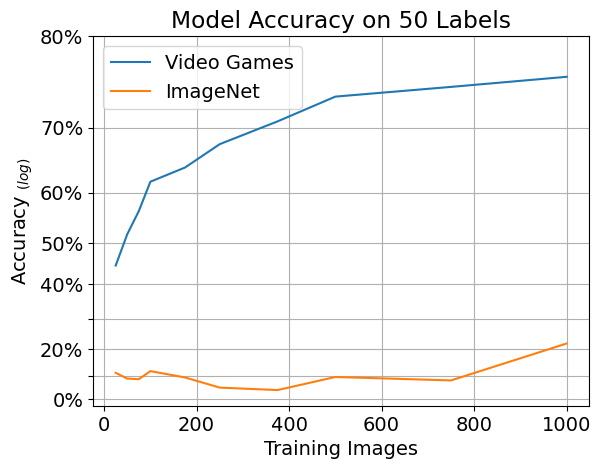

In [63]:
M=50
plt.plot(100-gamesAcc*100, label = "Video Games")
plt.plot(100-ImNetAcc*100, label = "ImageNet")
#plt.gca().invert_yaxis()
plt.yscale('log', base=10)
plt.gca().invert_yaxis()
plt.rcParams.update({'font.size': 14})
plt.grid(True, axis='both',ls="-")
plt.yticks([100, 90, 80, 70, 60, 50, 40, 30, 20], ['0%',  '', '20%', '', '40%', '50%', '60%', '70%', '80%'])
#plt.yticks([0.1, 0.5, 1, 2], ['0.1', '0.5', '1', '2'])
plt.xlabel('Training Images (per-label)')
plt.ylabel('Test Accuracy $_{(log)}$')
plt.title(f'Model Accuracy on {M} Labels')
plt.legend()
plt.savefig(f'Figures/{M}-Labels_Log_Acc.svg')

In [7]:
model = keras.saving.load_model(f'models/cnn_Games_{M:03d}_N-{N["train"]:04d}.keras')

I0000 00:00:1723663872.041020  429400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723663872.085394  429400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723663872.085481  429400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723663872.090417  429400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723663872.090517  429400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

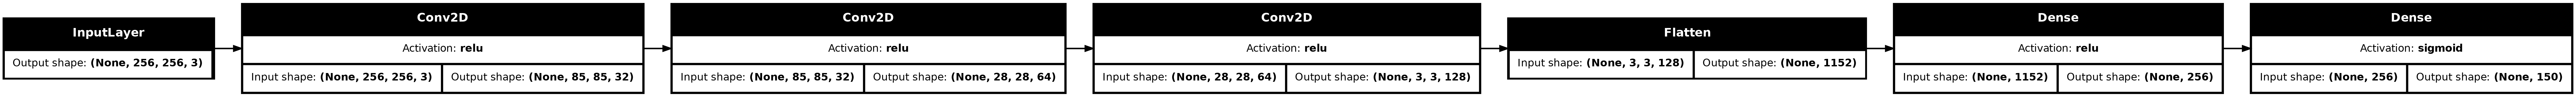

In [10]:
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="LR",
    expand_nested=False,
    dpi=200,
    show_layer_activations=True,
    show_trainable=False
)

In [18]:
def plotScoresM(callbacks, M = [10, 25, 50, 100, 150], n = 1040,datasets = ['ImageNet', 'Games'], batch_size=256):
    acc = {}
    loss = {}
    for dataset in datasets:
        acc[dataset] = {}
        loss[dataset] = {}
        for m in M:

            N={ #max samples per split #This block defines N according to testing needs
                'test':9999999, #only used for evaluation, so more only increases granularity
                'train':n,
                'val':65
            }
            
            if dataset == 'ImageNet':
                target = "./Data/150_subset/"
            elif dataset == 'Games':
                target = "./Data/Games/DATA BACKUP/"
            
            data, dataLabels, splits = getData(target, N, m=m)
            
            my_testing_batch_generator = My_Custom_Generator(data['test']['X'], data['test']['y'], 128, (256,256))

            model = keras.saving.load_model(f'models/cnn_{dataset}_{m:03d}_N-{N["train"]:04d}.keras')
            
            eval = model.evaluate(my_testing_batch_generator,
                      batch_size=128,
                      callbacks=callbacks,
                      return_dict=True
            )

            acc[dataset][m] = eval['accuracy']
            loss[dataset][m] = eval['loss']
    return acc, loss

In [21]:
acc, loss = plotScoresM(callbacks)
gamesAcc = pd.DataFrame.from_dict(acc['Games'], orient='index', columns=['Accuracy'])
ImNetAcc = pd.DataFrame.from_dict(acc['ImageNet'], orient='index', columns=['Accuracy'])

/home/king/miniconda3/envs/TensorFlows/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - accuracy: 0.0683 - loss: 10.1161
19/39 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.0306 - loss: 8.8049

KeyboardInterrupt: 

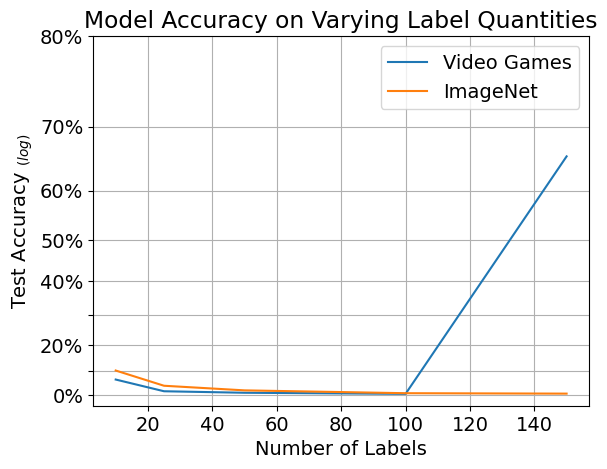

In [20]:
M=50
plt.plot(100-gamesAcc*100, label = "Video Games")
plt.plot(100-ImNetAcc*100, label = "ImageNet")
#plt.gca().invert_yaxis()
plt.yscale('log', base=10)
plt.gca().invert_yaxis()
plt.rcParams.update({'font.size': 14})
plt.grid(True, axis='both',ls="-")
plt.yticks([100, 90, 80, 70, 60, 50, 40, 30, 20], ['0%',  '', '20%', '', '40%', '50%', '60%', '70%', '80%'])
#plt.yticks([0.1, 0.5, 1, 2], ['0.1', '0.5', '1', '2'])
plt.xlabel('Number of Labels')
plt.ylabel('Test Accuracy $_{(log)}$')
plt.title(f'Model Accuracy on Varying Label Quantities')
plt.legend()
plt.savefig(f'Figures/M-Labels_Comparison.svg')